In [1]:
from matplotlib import pyplot as plt
import h5py
import numpy as np
import matplotlib.gridspec as gridspec
from scipy import spatial
from tqdm import *
import random
import os
import subprocess
import zipfile

cdm = h5py.File('Data/COLOR_CDM_DM_subHaloes_z0.00_v2.hdf5', 'r')
wdm = h5py.File('Data/COLOR_WDM_DM_subHaloes_z0.00_v2.hdf5', 'r')

cdm_galaxy = h5py.File('Data\COLOR_CDM_galaxies_z0.00.hdf5', 'r')
wdm_galaxy = h5py.File('Data\COLOR_WDM_galaxies_z0.00.hdf5', 'r')

print(cdm, wdm)

<HDF5 file "COLOR_CDM_DM_subHaloes_z0.00_v2.hdf5" (mode r)> <HDF5 file "COLOR_WDM_DM_subHaloes_z0.00_v2.hdf5" (mode r)>


# Find all galaxies that are as heavy as the Milky Way
### Access the masses and positions of CDM and WDM galaxies

In [2]:
# Access mass/position for wdm/cdm
print(list(cdm_galaxy.keys()),list(wdm_galaxy.keys()))

cdm_galaxy_color = cdm_galaxy['Colour'][:]
cdm_galaxy_position = cdm_galaxy['GalaxyPos'][:]
cdm_galaxy_mass = cdm_galaxy['StellarMass'][:]

wdm_galaxy_color = wdm_galaxy['Colour'][:]
wdm_galaxy_position = wdm_galaxy['GalaxyPos'][:]
wdm_galaxy_mass = wdm_galaxy['StellarMass'][:]

cdm_galaxy_color, cdm_galaxy_position, cdm_galaxy_mass, wdm_galaxy_color, wdm_galaxy_position, wdm_galaxy_mass

['Colour', 'GalaxyPos', 'HaloRvir', 'HostHaloMass', 'IsCentral', 'StellarMass'] ['Colour', 'GalaxyPos', 'HaloRvir', 'HostHaloMass', 'IsCentral', 'StellarMass']


(array([0.3074894 , 0.59537411, 0.59701824, ..., 0.59878778, 0.59881878,
        0.5967443 ]),
 array([[17.43208122, 80.25539398, 54.00876999],
        [17.43210793, 80.22522736, 53.97425079],
        [17.43374443, 80.27178955, 54.02692413],
        ...,
        [85.55805969,  1.73876286, 65.28675079],
        [52.84350586, 10.11826706, 16.42269516],
        [55.3265419 , 34.21372986, 28.35575867]]),
 array([1.86803984e+08, 3.18429395e+04, 4.78547754e+03, ...,
        5.03134871e+00, 2.88395190e+00, 2.04510657e+03]),
 array([0.29522324, 0.29758644, 0.5930109 , ..., 0.59763646, 0.59827816,
        0.59777474]),
 array([[17.61932182, 79.06235504, 52.68593979],
        [18.65647697, 80.58162689, 52.30108261],
        [18.58250046, 80.91363525, 52.45199203],
        ...,
        [78.62889862, 83.76999664, 61.69128036],
        [97.51596069, 36.17467499, 37.83997726],
        [ 6.65006733, 48.75699997, 51.62447739]]),
 array([3.12070700e+06, 4.30492600e+06, 8.09484188e+05, ...,
        1.59

### Access the masses and positions of CDM and WDM halos

In [3]:
# Access mass/position for wdm/cdm
print(list(cdm.keys()),list(wdm.keys()))

cdm_mass = cdm['SubhaloMass'][:]
cdm_position = cdm['SubhaloPos'][:]

wdm_mass = wdm['SubhaloMass'][:]
wdm_position = wdm['SubhaloPos'][:]

cdm_mass, cdm_position, wdm_mass, wdm_position

['IsCentral', 'R200', 'SubhaloMass', 'SubhaloPos'] ['IsCentral', 'R200', 'SubhaloMass', 'SubhaloPos']


(array([1.87617493e+14, 1.84468594e+14, 6.89978024e+13, ...,
        1.76011232e+08, 1.76011232e+08, 1.76011232e+08]),
 array([[10.93832207, 81.23078918, 54.77935028],
        [17.94562721, 79.86347961, 53.3843956 ],
        [15.62266159, 78.18474579, 52.83857346],
        ...,
        [ 1.47748184,  3.54455233, 99.53264618],
        [99.32190704,  2.56014371,  2.57368279],
        [99.0621109 ,  4.18381071,  2.89533401]]),
 array([1.89941540e+14, 1.86912732e+14, 6.83256610e+13, ...,
        1.76011232e+08, 1.76011232e+08, 1.76011232e+08]),
 array([[1.80150642e+01, 7.98655701e+01, 5.34328232e+01],
        [1.09048624e+01, 8.12610779e+01, 5.48179703e+01],
        [1.56323385e+01, 7.81665344e+01, 5.28157997e+01],
        ...,
        [6.02296066e+00, 5.05078554e+00, 9.79758301e+01],
        [5.75055540e-01, 3.26677370e+00, 3.52767438e-01],
        [2.07897183e-03, 3.23730040e+00, 9.97708917e-01]]))

### Define a function

In [4]:
def create_tree(galaxy_mass, galaxy, galaxy_position, mass, dm, position, m_min, issat, label):
    
    # get the indices and positions of all central galaxies within the mass range $2-6*10^{10}$ M$_{\odot}$
    MW_galaxy_ind = np.where((galaxy_mass > 2*10**10) & (galaxy_mass < 6*10**10) & (galaxy['IsCentral'][:] == 1))[0]
    MW_galaxy_position = galaxy_position[MW_galaxy_ind]
    
    # filter out galaxies below a certain minimum mass, as well as satellites if necessary
    if issat == 1:
        mask = np.where(galaxy_mass > m_min)[0]
    else:
        mask = np.where((galaxy_mass > m_min) & (galaxy['IsCentral'][:] == 1))[0]
    sat, tot = galaxy['IsCentral'][:][mask], len(mask)
    print(label + ': {:<9.3f} N_gal: {:<9}'.format(len(np.where(sat == 0)[0])/tot*100, tot))
        
    # create the trees with the filtered galaxies to search through
    galaxy_mass_filtered, galaxy_position_filtered = galaxy_mass[mask], galaxy_position[mask]
    tree = spatial.cKDTree(galaxy_position_filtered)
    
    # get the indices and positions of all central halos within the mass range $0.8-2*10^{12}$ M$_{\odot}$
    MW_ind = np.where((mass > 0.8*10**12) & (mass < 2*10**12) & (dm['IsCentral'][:] == 1))[0]
    MW_position = position[MW_ind]
    
    return MW_galaxy_ind, MW_galaxy_position, galaxy_mass_filtered, galaxy_position_filtered, tree, MW_ind, MW_position, sat
    
def shell_calc(MW_position, tree, VR, MW_ind, position_filtered, mass_filtered, sat):
    
    # create an empty array for the indices of the galaxies
    Mpc_sphere, VR_sphere, shell, shell_mass, shell_sat= [], [], [], [], []

    # iterate through each MW-sized galaxy
    for i in trange(len(MW_position)):

        # find the indices of all galaxies in a 3 Mpc radius around each MW-sized galaxy
        ind_3Mpc = tree.query_ball_point(MW_position[i], 3)
        Mpc_sphere.append(ind_3Mpc)

        # find the indices of all galaxies within the virial radius of each MW-sized galaxy's host halo
        ind_VR = tree.query_ball_point(MW_position[i], VR[:][MW_ind[i]])
        VR_sphere.append(ind_VR)

        # find the indices of all galaxies that are not within the virial radius of each halo
        ind = [j for j in Mpc_sphere[i] if j not in VR_sphere[i]]
        shell.append(position_filtered[ind])
        shell_mass.extend(mass_filtered[ind])
        shell_sat.extend(sat[ind])

    return shell, shell_mass, shell_sat
        
def shell_zip(cdm_galaxy_mass, wdm_galaxy_mass, cdm_galaxy, wdm_galaxy, cdm_mass, wdm_mass, cdm, wdm, m_min = 0, issat = 1):
    
    # calculate the tree based on a minimum galaxy mass
    print('Calculating the satellite percentage...\n')
    cdm_params = create_tree(cdm_galaxy_mass, cdm_galaxy, cdm_galaxy_position, cdm_mass, cdm, cdm_position, m_min, issat, 
                             'CDM')
    wdm_params = create_tree(wdm_galaxy_mass, wdm_galaxy, wdm_galaxy_position, wdm_mass, wdm, wdm_position, m_min, issat, 
                             'WDM')
    
    # save the parameters
    [cdm_MW_galaxy_ind, cdm_MW_galaxy_position, cdm_galaxy_mass_filtered, cdm_galaxy_position_filtered, cdm_tree, 
     cdm_MW_ind, cdm_MW_position, cdm_sat] = cdm_params
    [wdm_MW_galaxy_ind, wdm_MW_galaxy_position, wdm_galaxy_mass_filtered, wdm_galaxy_position_filtered, wdm_tree, 
     wdm_MW_ind, wdm_MW_position, wdm_sat] = wdm_params

    # calculate the shells according to galaxy mass
    cdm_galaxy_params = shell_calc(cdm_MW_galaxy_position, cdm_tree, cdm_galaxy['HaloRvir'], cdm_MW_galaxy_ind, 
                                   cdm_galaxy_position_filtered, cdm_galaxy_mass_filtered, cdm_sat)
    wdm_galaxy_params = shell_calc(wdm_MW_galaxy_position, wdm_tree, wdm_galaxy['HaloRvir'], wdm_MW_galaxy_ind, 
                                   wdm_galaxy_position_filtered, wdm_galaxy_mass_filtered, wdm_sat)
    cdm_shell_galaxy, cdm_shell_mass_galaxy, cdm_shell_sat_galaxy = cdm_galaxy_params
    wdm_shell_galaxy, wdm_shell_mass_galaxy, wdm_shell_sat_galaxy = wdm_galaxy_params

    # calculate the shells according to halo mass
    cdm_shell, cdm_shell_mass, cdm_shell_sat = shell_calc(cdm_MW_position, cdm_tree, cdm['R200'], cdm_MW_ind, 
                                                          cdm_galaxy_position_filtered, cdm_galaxy_mass_filtered, cdm_sat)
    wdm_shell, wdm_shell_mass, wdm_shell_sat = shell_calc(wdm_MW_position, wdm_tree, wdm['R200'], wdm_MW_ind, 
                                                          wdm_galaxy_position_filtered, wdm_galaxy_mass_filtered, wdm_sat)

    # record the average number of galaxies and satellite fraction in each shell        
    print('Minimum Mass:', str(m_min), 'solar masses\n')
    for shell, label, tag, sat in zip([cdm_shell_galaxy, wdm_shell_galaxy, cdm_shell, wdm_shell], 
                                      ['CDM', 'WDM', 'CDM', 'WDM'], ['Galaxy Method', '', 'Halo Method', ''],
                                      [cdm_shell_sat_galaxy, wdm_shell_sat_galaxy, cdm_shell_sat, wdm_shell_sat]):
        shell_length = []
        for galaxy in shell:
            shell_length.append(len(galaxy))
        nsat, mgal = (1 - np.sum(sat)/np.sum(shell_length))*100, np.mean(shell_length)
        print('{:<17}'.format(tag) + label + ': {:<10.3f} M_gal: {:<9.3}'.format(nsat, mgal))
        
    # plot the abundance of galaxies in each selection
    plt.figure(figsize=(16,4))
    grid = gridspec.GridSpec(1,2)
    grid.update(hspace = 0)
    grid0 = plt.subplot(grid[0])
    grid1 = plt.subplot(grid[1])
    
    # plot the stellar mass of galaxies in each selection
    for label, cdm_plot, wdm_plot, grid in zip(['Galaxies', 'Halos'], [cdm_shell_mass_galaxy, cdm_shell_mass], 
                                               [wdm_shell_mass_galaxy, wdm_shell_mass], [grid0, grid1]):
    
        # label the plots
        if issat == 1:
            data, loc = r'Data: Central and Satellite galaxies', 10**5.5
        else:
            data, loc = r'Data: Central galaxies', 10**6
        textstr = '\n'.join((data, r'Minimum Stellar Mass: ' + str(m_min) + ' M$_{\odot}$'))
        props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

        # set up the plots
        bins = np.logspace(-0.25, 10.5, 50)
        grid.hist(cdm_plot, bins = bins, label = "Cold Dark Matter", color = 'blue')
        grid.hist(wdm_plot, bins = bins, label = "Sterile Neutrino, 7 keV", color = 'red')
        grid.text(loc, 72500, textstr, verticalalignment='top', bbox=props)
        grid.set_xlabel('Stellar Mass (M$_\odot$)')
        grid.set_ylabel('Abundance of Galaxies')
        grid.set_xlim(10**-0.25,10**10.5)
        grid.set_ylim(0, 92500)
        grid.set_xscale("Log")
        grid.set_title('Milky Way-Mass ' + label)
        grid.legend()
        
    # plot!
    plt.show()
    
    # Create an input folder 
    home = "C:\\Users\\Mahlet Shiferaw\\OneDrive\\Dell\\Astro_98"
    folder = home + "\\Input\\local\\"
    if not os.path.exists(folder):
        os.mkdir(folder)

    # iterate through each result
    for position, label, name in zip([cdm_shell_galaxy, wdm_shell_galaxy, cdm_shell, wdm_shell], 
                                     ["cdm_", "wdm_", "cdm_", "wdm_"], ["local_galaxy_position", "local_galaxy_position",
                                                                        "local_halo_position", "local_halo_position"]):

        # iterate through each MW-sized cdm galaxy
        for i in range(len(position)):

            # save the galaxy positions
            file = label + name + str(i) + ".txt"
            np.savetxt(folder + file, position[i], fmt = "%f %f %f")

            # zip each input file
            os.chdir(folder)
            subprocess.call(['zip', '-ur', name + '_m' + str(m_min) + '_s' + str(issat) + '.zip', file])
            os.chdir(home)
        
    print('\nDone!')

### Set M$_{\mathrm{min}}$ = 0 M$_{\odot}$ , including satellites

Calculating the satellite percentage...

CDM: 75.923    N_gal: 2024520  
WDM: 76.186    N_gal: 893532   


100%|██████████████████████████████████████████████████████████████████████████████| 1065/1065 [00:17<00:00, 60.08it/s]


Minimum Mass: 0 solar masses

Galaxy Method    CDM: 87.529     M_gal: 1915.6315789473683
                 WDM: 88.898     M_gal: 1043.933660933661
Halo Method      CDM: 80.907     M_gal: 966.5430463576159
                 WDM: 81.106     M_gal: 432.89014084507045


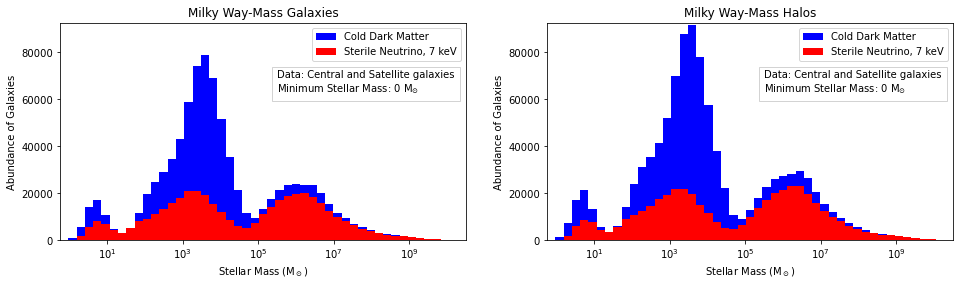

In [5]:
shell_zip(cdm_galaxy_mass, wdm_galaxy_mass, cdm_galaxy, wdm_galaxy, cdm_mass, wdm_mass, cdm, wdm)

### Set M$_{\mathrm{min}}$ = 1000 M$_{\odot}$, including satellites

Calculating the satellite percentage...

CDM: 76.499    N_gal: 1493563  
WDM: 74.454    N_gal: 666438   


100%|██████████████████████████████████████████████████████████████████████████████| 1065/1065 [00:18<00:00, 58.70it/s]


Minimum Mass: 1000 solar masses

Galaxy Method    CDM: 87.885     M_gal: 1440.342105263158
                 WDM: 88.045     M_gal: 776.5798525798526
Halo Method      CDM: 81.227     M_gal: 716.7644276253548
                 WDM: 79.598     M_gal: 321.87136150234744


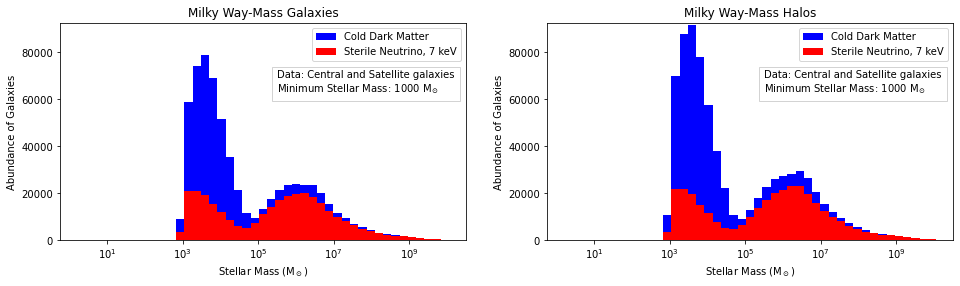

In [6]:
shell_zip(cdm_galaxy_mass, wdm_galaxy_mass, cdm_galaxy, wdm_galaxy, cdm_mass, wdm_mass, cdm, wdm, m_min = 1000)

### Set M$_{\mathrm{min}}$ = 0 M$_{\odot}$ , centrals only

Calculating the satellite percentage...

CDM: 0.000     N_gal: 487451   


  0%|                                                                                          | 0/456 [00:00<?, ?it/s]

WDM: 0.000     N_gal: 212786   


100%|██████████████████████████████████████████████████████████████████████████████| 1065/1065 [00:18<00:00, 57.64it/s]


Minimum Mass: 0 solar masses

Galaxy Method    CDM: 0.000      M_gal: 238.90350877192984
                 WDM: 0.000      M_gal: 115.8968058968059
Halo Method      CDM: 0.000      M_gal: 184.5411542100284
                 WDM: 0.000      M_gal: 81.7906103286385


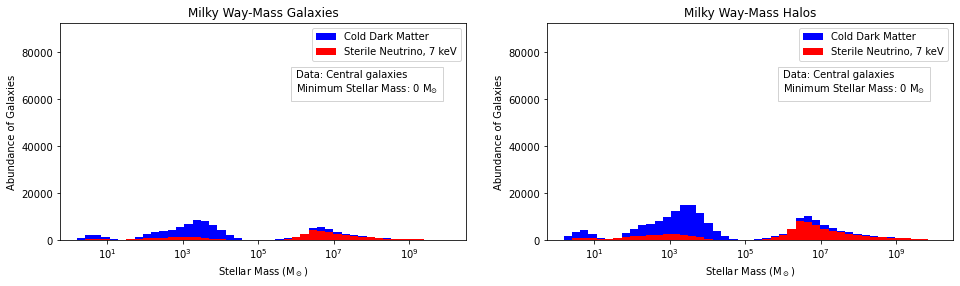

In [7]:
shell_zip(cdm_galaxy_mass, wdm_galaxy_mass, cdm_galaxy, wdm_galaxy, cdm_mass, wdm_mass, cdm, wdm, issat = 0)

### Set M$_{\mathrm{min}}$ = 1000 M$_{\odot}$ , centrals only

Calculating the satellite percentage...

CDM: 0.000     N_gal: 350995   


  0%|                                                                                          | 0/456 [00:00<?, ?it/s]

WDM: 0.000     N_gal: 170249   


100%|██████████████████████████████████████████████████████████████████████████████| 1065/1065 [00:18<00:00, 56.15it/s]


Minimum Mass: 1000 solar masses

Galaxy Method    CDM: 0.000      M_gal: 174.50438596491227
                 WDM: 0.000      M_gal: 92.84029484029485
Halo Method      CDM: 0.000      M_gal: 134.55534531693473
                 WDM: 0.000      M_gal: 65.66760563380282


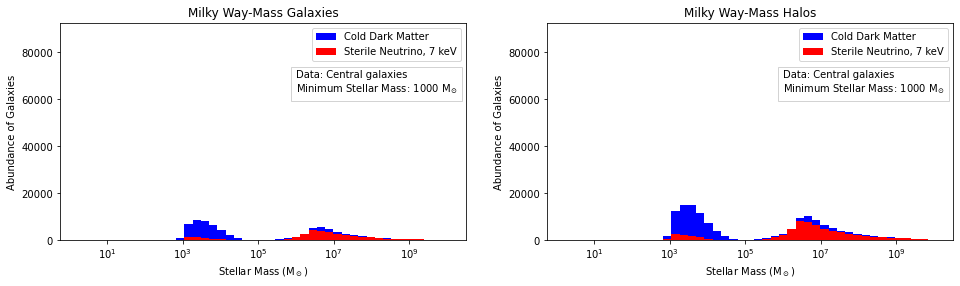

In [8]:
shell_zip(cdm_galaxy_mass, wdm_galaxy_mass, cdm_galaxy, wdm_galaxy, cdm_mass, wdm_mass, cdm, wdm, m_min = 1000, issat = 0)

# Compute the average correlation function of MW-sized galaxies and halos
### Import the output data from Odyssey

In [9]:
def shell_corr(m_min = 0, issat = 1, home = "C:\\Users\\Mahlet Shiferaw\\OneDrive\\Dell\\Astro_98", save = False):
    
    # create empty arrays
    mass, is_satellite, folder = '_m' + str(m_min), '_s' + str(issat), home + "\\Output\\" 
    shell_galaxy, shell_halo = {'cdm':[],'wdm':[]}, {'cdm':[], 'wdm':[]}

    # iterate through each zip file
    for zip_file, shell, title, save_file in zip(['_galaxy_', '_halo_'], [shell_galaxy, shell_halo], ['Galaxies', 'Halos'], 
                                            [save, False]):

        # make an output folder
        name = 'local' + zip_file + 'position' + mass + is_satellite
        if not os.path.exists(folder + name):
            os.mkdir(folder + name)

        # move the zip file into the output folder
        if os.path.exists(folder + name + '.zip'):
            if os.path.exists(folder + name + '\\' + name + '.zip'):
                os.remove(folder + name + '\\' + name + '.zip')
            os.rename(folder + name + '.zip', folder + name + '\\' + name + '.zip')

        # extract the files
        os.chdir(folder + name)
        with zipfile.ZipFile(name + '.zip', 'r') as zip_ref:
            zip_ref.extractall()

        # save the files
        for label in ['cdm', 'wdm']:
            for txt_file in [file for file in os.listdir() if file.startswith("corr_" + label)]:
                shell[label].append(np.genfromtxt(folder + name + '\\' + txt_file))
        os.chdir(home)
        
        # plot the correlation function
        CUTE_cdm, cdm_std = np.mean(shell['cdm'], axis = 0), np.std(shell['cdm'], axis = 0)[:,1]
        CUTE_wdm, wdm_std = np.mean(shell['wdm'], axis = 0), np.std(shell['wdm'], axis = 0)[:,1]
        err = np.sqrt((wdm_std/CUTE_wdm[:,1])**2+(cdm_std/CUTE_cdm[:,1])**2)*CUTE_wdm[:,1]/CUTE_cdm[:,1]

        if issat == 1:
            data = r'Data: Central and Satellite galaxies'
        else:
            data = r'Data: Central galaxies'
        textstr = '\n'.join((data, r'Minimum Stellar Mass: ' + str(m_min) + ' M$_{\odot}$'))
        props = dict(facecolor='white', edgecolor='lightgrey', pad = 5.0)

        plt.figure(figsize=(10,8))
        grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
        grid.update(hspace = 0)
        grid0 = plt.subplot(grid[0])
        grid1 = plt.subplot(grid[1])

        grid0.errorbar(CUTE_cdm[:,0], CUTE_cdm[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue", 
                       yerr = cdm_std, capsize = 5, capthick = 5)
        grid0.errorbar(CUTE_wdm[:,0], CUTE_wdm[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red", 
                       yerr = wdm_std, capsize = 5, capthick = 5)
        grid0.set_ylim(10**0.5, 10**8.25)
        grid0.set_ylabel(r"$\overline{\xi(r)}$", fontsize = 32)
        grid0.legend(fontsize=16)
        grid0.text(0.05, 0.2, textstr, transform = grid0.transAxes, fontsize = 16, verticalalignment = 'top', bbox = props)
        if save_file == False:
            grid0.set_title('Milky Way-Mass ' + title, fontsize = 32)
        grid0.set_yscale('Log')

        grid1.errorbar(CUTE_wdm[:,0], CUTE_wdm[:,1]/CUTE_cdm[:,1], linewidth = 5, color = "green", yerr = err, capsize = 5, 
                       capthick = 5)
        grid1.set_xlabel("Radius/Mpc", fontsize = 32)
        grid1.set_ylabel("Ratio",  fontsize = 20)
        grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
        grid1.set_ylim(0, 2)
        grid1.yaxis.grid(which = "both")
        
        for grid in [grid0, grid1]:
            grid.set_xlim(5*10**-3, 2e1)
            grid.minorticks_on()
            grid.tick_params(labelsize=16)
            grid.set_xscale('Log')

        if save_file == True:
            plt.savefig('Images/Summer2020/' + name + '_std.pdf', bbox_inches = "tight")
        plt.show()
        
    return shell_galaxy, shell_halo

### Set M$_{\mathrm{min}}$ = 0 M$_{\odot}$, including satellites

<ipython-input-9-acecfd7a0800>:36: RuntimeWarning: invalid value encountered in true_divide
  err = np.sqrt((wdm_std/CUTE_wdm[:,1])**2+(cdm_std/CUTE_cdm[:,1])**2)*CUTE_wdm[:,1]/CUTE_cdm[:,1]
<ipython-input-9-acecfd7a0800>:63: RuntimeWarning: invalid value encountered in true_divide
  grid1.errorbar(CUTE_wdm[:,0], CUTE_wdm[:,1]/CUTE_cdm[:,1], linewidth = 5, color = "green", yerr = err, capsize = 5,


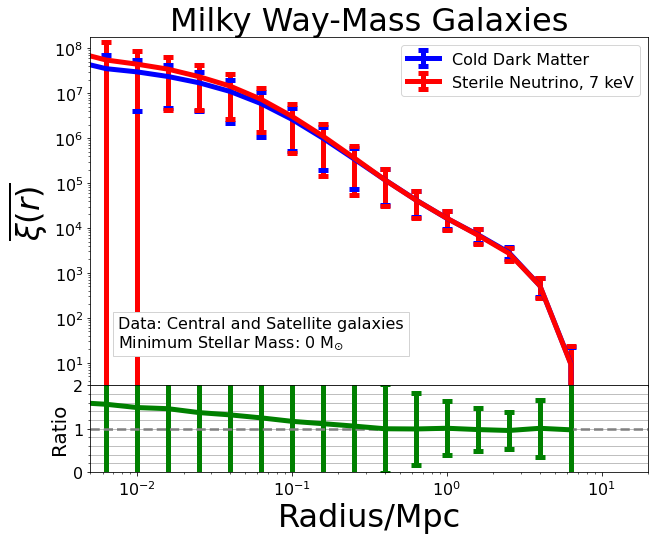

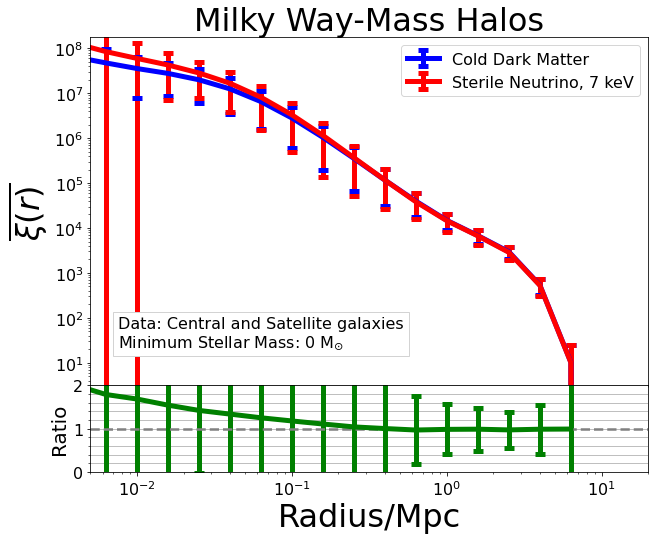

In [10]:
shell_galaxy, shell_halo = shell_corr()

### Set M$_{\mathrm{min}}$ = 1000 M$_{\odot}$, including satellites

<ipython-input-9-acecfd7a0800>:36: RuntimeWarning: invalid value encountered in true_divide
  err = np.sqrt((wdm_std/CUTE_wdm[:,1])**2+(cdm_std/CUTE_cdm[:,1])**2)*CUTE_wdm[:,1]/CUTE_cdm[:,1]
<ipython-input-9-acecfd7a0800>:63: RuntimeWarning: invalid value encountered in true_divide
  grid1.errorbar(CUTE_wdm[:,0], CUTE_wdm[:,1]/CUTE_cdm[:,1], linewidth = 5, color = "green", yerr = err, capsize = 5,


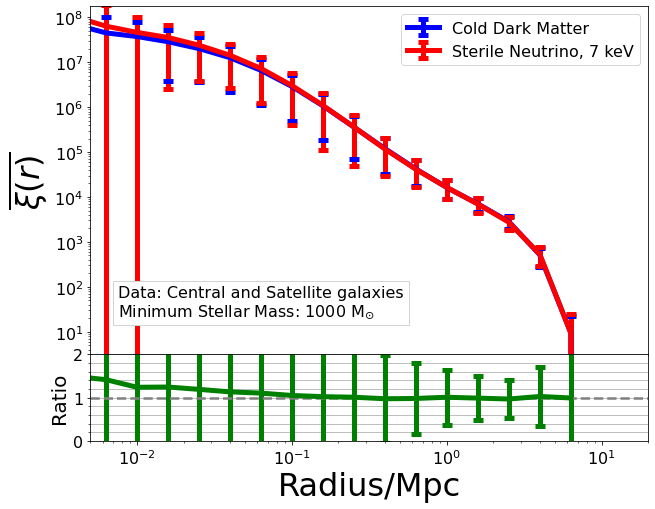

<ipython-input-9-acecfd7a0800>:36: RuntimeWarning: invalid value encountered in true_divide
  err = np.sqrt((wdm_std/CUTE_wdm[:,1])**2+(cdm_std/CUTE_cdm[:,1])**2)*CUTE_wdm[:,1]/CUTE_cdm[:,1]
<ipython-input-9-acecfd7a0800>:63: RuntimeWarning: invalid value encountered in true_divide
  grid1.errorbar(CUTE_wdm[:,0], CUTE_wdm[:,1]/CUTE_cdm[:,1], linewidth = 5, color = "green", yerr = err, capsize = 5,


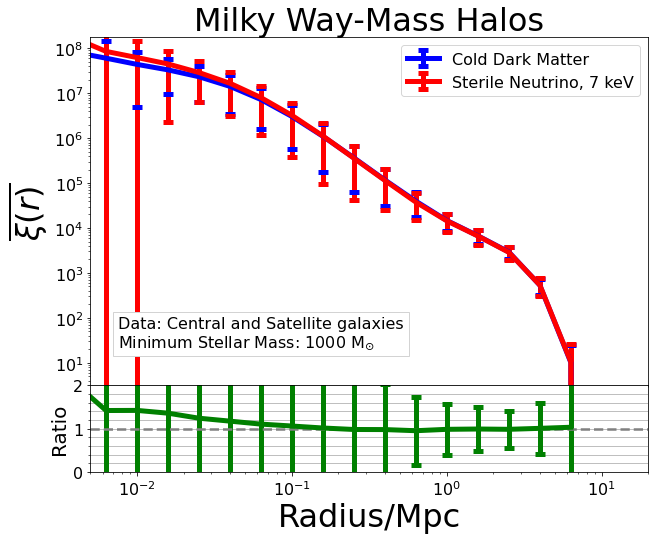

In [11]:
shell_galaxy, shell_halo = shell_corr(m_min = 1000, save = True)

### Set M$_{\mathrm{min}}$ = 0 M$_{\odot}$, centrals only

<ipython-input-9-acecfd7a0800>:36: RuntimeWarning: invalid value encountered in true_divide
  err = np.sqrt((wdm_std/CUTE_wdm[:,1])**2+(cdm_std/CUTE_cdm[:,1])**2)*CUTE_wdm[:,1]/CUTE_cdm[:,1]
<ipython-input-9-acecfd7a0800>:63: RuntimeWarning: invalid value encountered in true_divide
  grid1.errorbar(CUTE_wdm[:,0], CUTE_wdm[:,1]/CUTE_cdm[:,1], linewidth = 5, color = "green", yerr = err, capsize = 5,


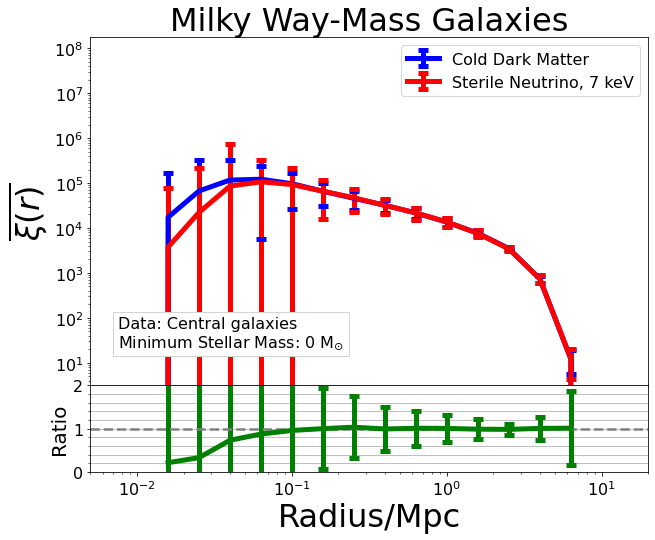

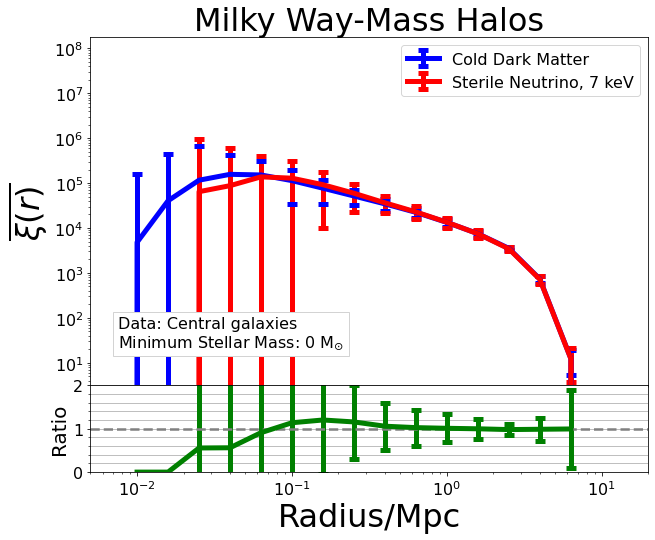

In [12]:
shell_galaxy, shell_halo = shell_corr(issat = 0)

### Set M$_{\mathrm{min}}$ = 1000 M$_{\odot}$, centrals only

<ipython-input-9-acecfd7a0800>:36: RuntimeWarning: invalid value encountered in true_divide
  err = np.sqrt((wdm_std/CUTE_wdm[:,1])**2+(cdm_std/CUTE_cdm[:,1])**2)*CUTE_wdm[:,1]/CUTE_cdm[:,1]
<ipython-input-9-acecfd7a0800>:63: RuntimeWarning: invalid value encountered in true_divide
  grid1.errorbar(CUTE_wdm[:,0], CUTE_wdm[:,1]/CUTE_cdm[:,1], linewidth = 5, color = "green", yerr = err, capsize = 5,


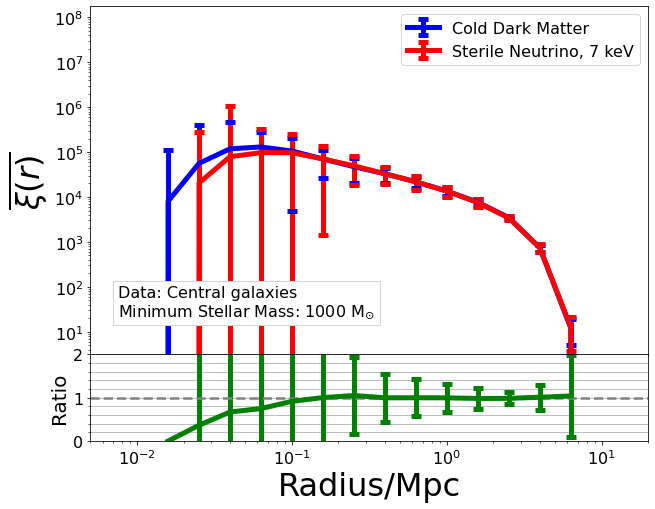

<ipython-input-9-acecfd7a0800>:36: RuntimeWarning: invalid value encountered in true_divide
  err = np.sqrt((wdm_std/CUTE_wdm[:,1])**2+(cdm_std/CUTE_cdm[:,1])**2)*CUTE_wdm[:,1]/CUTE_cdm[:,1]
<ipython-input-9-acecfd7a0800>:63: RuntimeWarning: invalid value encountered in true_divide
  grid1.errorbar(CUTE_wdm[:,0], CUTE_wdm[:,1]/CUTE_cdm[:,1], linewidth = 5, color = "green", yerr = err, capsize = 5,


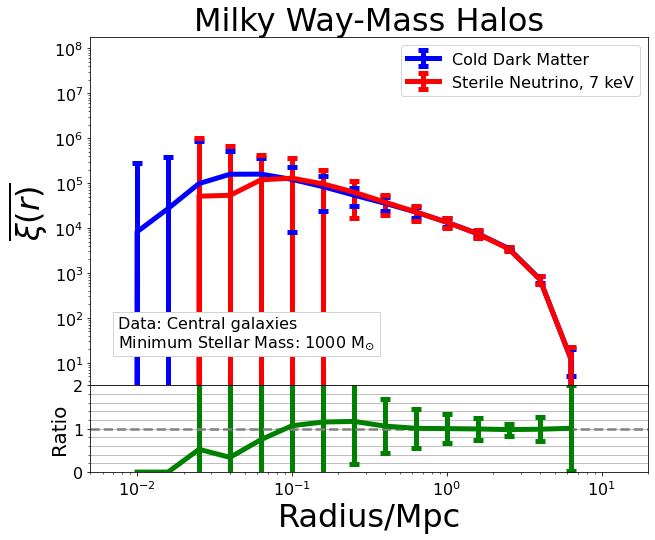

In [13]:
shell_galaxy, shell_halo = shell_corr(m_min = 1000, issat = 0, save = True)

# Repeat using non-periodic CUTE!

In [14]:
def shell_corrfunc(m_min = 0, issat = 1, home = "C:\\Users\\Mahlet Shiferaw\\OneDrive\\Dell\\Astro_98", save = False):
    
    # create empty arrays
    mass, is_satellite, folder = '_m' + str(m_min), '_s' + str(issat), home + "\\Output\\corrfunc\\" 
    shell_galaxy, shell_halo = {'cdm':[],'wdm':[]}, {'cdm':[], 'wdm':[]}

    # iterate through each zip file
    for zip_file, shell, title, save_file in zip(['_galaxy_', '_halo_'], [shell_galaxy, shell_halo], ['Galaxies', 'Halos'], 
                                            [save, False]):

        # make an output folder
        name = 'local' + zip_file + 'position' + mass + is_satellite
        if not os.path.exists(folder + name):
            os.mkdir(folder + name)

        # move the zip file into the output folder
        if os.path.exists(folder + name + '.zip'):
            if os.path.exists(folder + name + '\\' + name + '.zip'):
                os.remove(folder + name + '\\' + name + '.zip')
            os.rename(folder + name + '.zip', folder + name + '\\' + name + '.zip')

        # extract the files
        os.chdir(folder + name)
        with zipfile.ZipFile(name + '.zip', 'r') as zip_ref:
            zip_ref.extractall()

        # save the files
        for label in ['cdm', 'wdm']:
            for txt_file in [file for file in os.listdir() if file.startswith("corr_" + label)]:
                shell[label].append(np.genfromtxt(folder + name + '\\' + txt_file))
        os.chdir(home)
        
        # plot the correlation function
        CUTE_cdm, cdm_std = np.nanmean(shell['cdm'], axis = 0), np.nanstd(shell['cdm'], axis = 0)
        CUTE_wdm, wdm_std = np.nanmean(shell['wdm'], axis = 0), np.nanstd(shell['wdm'], axis = 0)
        err = np.sqrt((wdm_std/CUTE_wdm)**2+(cdm_std/CUTE_cdm)**2)*CUTE_wdm/CUTE_cdm
        bins_old = np.logspace(-2, 0.8, 15)
        bins_new = 0.5 * ( bins_old[1:] + bins_old[:-1])

        if issat == 1:
            data = r'Data: Central and Satellite galaxies'
        else:
            data = r'Data: Central galaxies'
        textstr = '\n'.join((data, r'Minimum Stellar Mass: ' + str(m_min) + ' M$_{\odot}$'))
        props = dict(facecolor='white', edgecolor='lightgrey', pad = 5.0)

        plt.figure(figsize=(10,8))
        grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
        grid.update(hspace = 0)
        grid0 = plt.subplot(grid[0])
        grid1 = plt.subplot(grid[1])

        grid0.errorbar(bins_new, CUTE_cdm, label = "Cold Dark Matter", linewidth = 5, color = "blue", 
                       yerr = cdm_std, capsize = 5, capthick = 5)
        grid0.errorbar(bins_new, CUTE_wdm, label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red", 
                       yerr = wdm_std, capsize = 5, capthick = 5)
        grid0.set_ylim(10**1.25, 10**6.75)
        grid0.set_ylabel(r"$\overline{\xi(r)}$", fontsize = 32)
        grid0.legend(fontsize = 16)
        grid0.text(0.05, 0.15, textstr, transform = grid0.transAxes, fontsize = 16, verticalalignment = 'top', bbox = props)
        if save_file == False:
            grid0.set_title('Milky Way-Mass ' + title, fontsize = 32)
        grid0.set_yscale('Log')

        grid1.errorbar(bins_new, CUTE_wdm/CUTE_cdm, linewidth = 5, color = "green", yerr = err, capsize = 5, 
                       capthick = 5)
        grid1.set_xlabel("Radius/Mpc", fontsize = 32)
        grid1.set_ylabel("Ratio",  fontsize = 20)
        grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
        grid1.set_ylim(-0.5, 2.5)
        grid1.yaxis.grid(which = "both")
        
        for grid in [grid0, grid1]:
            grid.set_xlim(5*10**-3, 2e1)
            grid.minorticks_on()
            grid.tick_params(labelsize = 16)
            grid.set_xscale('Log')

        if save_file == True:
            plt.savefig('Images/Summer2020/corrfunc_' + name + '_std.pdf', bbox_inches = "tight")
        plt.show()
        
    return shell_galaxy, shell_halo

### Set M$_{\mathrm{min}}$ = 0 M$_{\odot}$, including satellites

<ipython-input-14-119f98635098>:34: RuntimeWarning: Mean of empty slice
  CUTE_cdm, cdm_std = np.nanmean(shell['cdm'], axis = 0), np.nanstd(shell['cdm'], axis = 0)
<ipython-input-14-119f98635098>:35: RuntimeWarning: Mean of empty slice
  CUTE_wdm, wdm_std = np.nanmean(shell['wdm'], axis = 0), np.nanstd(shell['wdm'], axis = 0)


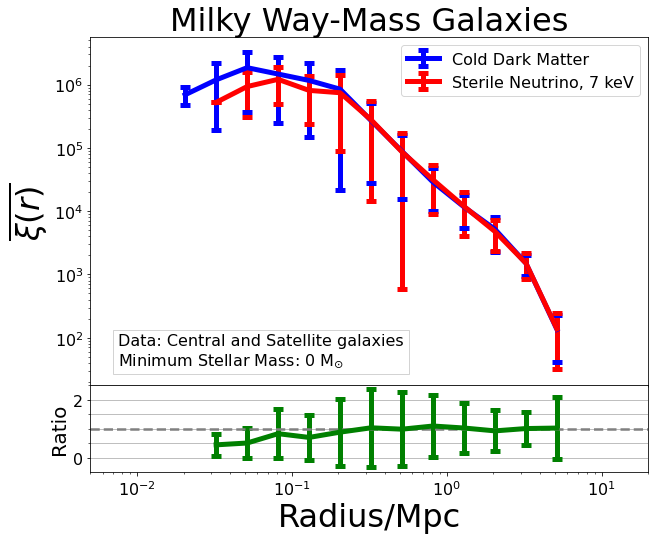

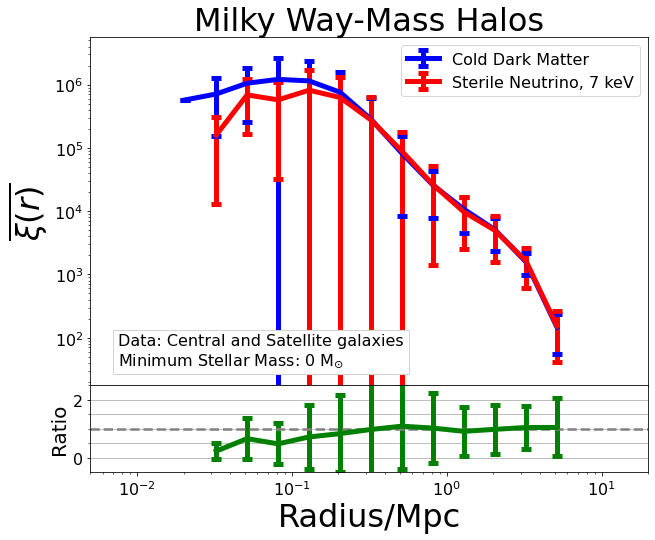

In [15]:
shell_galaxy, shell_halo = shell_corrfunc()

### Set M$_{\mathrm{min}}$ = 1000 M$_{\odot}$, including satellites

<ipython-input-14-119f98635098>:34: RuntimeWarning: Mean of empty slice
  CUTE_cdm, cdm_std = np.nanmean(shell['cdm'], axis = 0), np.nanstd(shell['cdm'], axis = 0)
<ipython-input-14-119f98635098>:35: RuntimeWarning: Mean of empty slice
  CUTE_wdm, wdm_std = np.nanmean(shell['wdm'], axis = 0), np.nanstd(shell['wdm'], axis = 0)


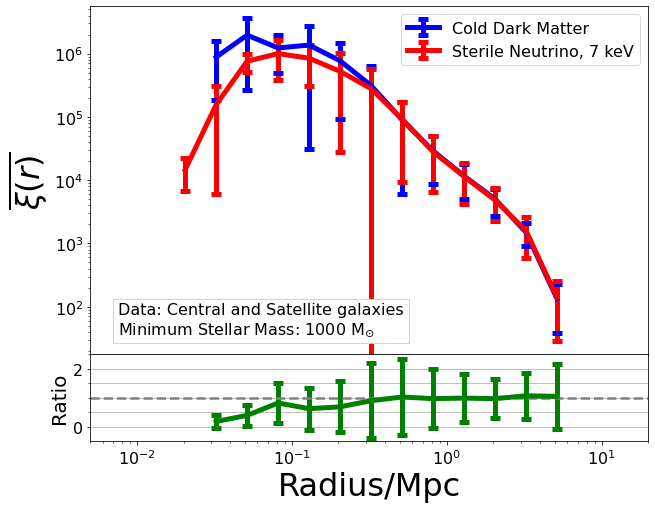

<ipython-input-14-119f98635098>:34: RuntimeWarning: Mean of empty slice
  CUTE_cdm, cdm_std = np.nanmean(shell['cdm'], axis = 0), np.nanstd(shell['cdm'], axis = 0)
C:\Users\Mahlet Shiferaw\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-14-119f98635098>:35: RuntimeWarning: Mean of empty slice
  CUTE_wdm, wdm_std = np.nanmean(shell['wdm'], axis = 0), np.nanstd(shell['wdm'], axis = 0)


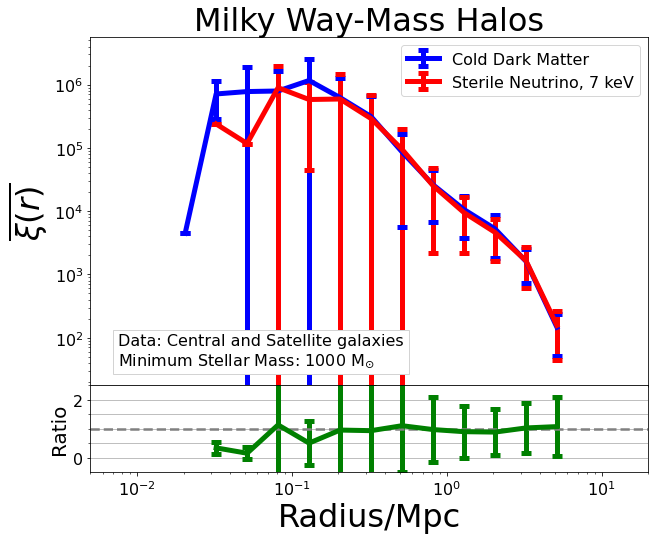

In [16]:
shell_galaxy_satellites, shell_halo_satellites = shell_corrfunc(m_min = 1000, save = True)

### Set M$_{\mathrm{min}}$ = 0 M$_{\odot}$, centrals only

<ipython-input-14-119f98635098>:34: RuntimeWarning: Mean of empty slice
  CUTE_cdm, cdm_std = np.nanmean(shell['cdm'], axis = 0), np.nanstd(shell['cdm'], axis = 0)
<ipython-input-14-119f98635098>:35: RuntimeWarning: Mean of empty slice
  CUTE_wdm, wdm_std = np.nanmean(shell['wdm'], axis = 0), np.nanstd(shell['wdm'], axis = 0)


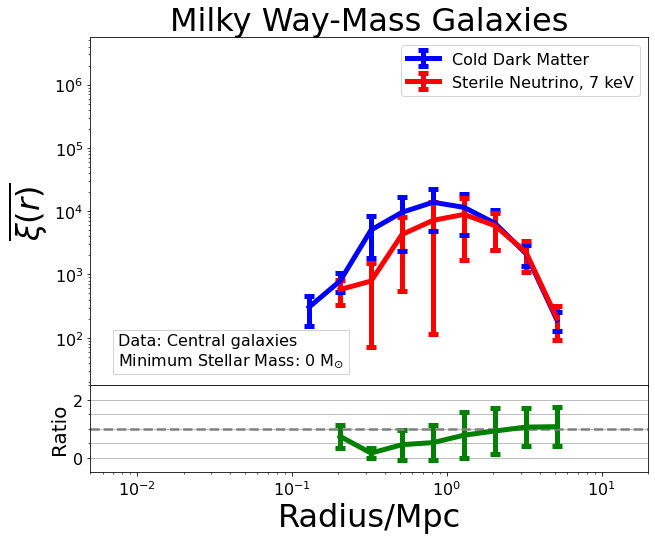

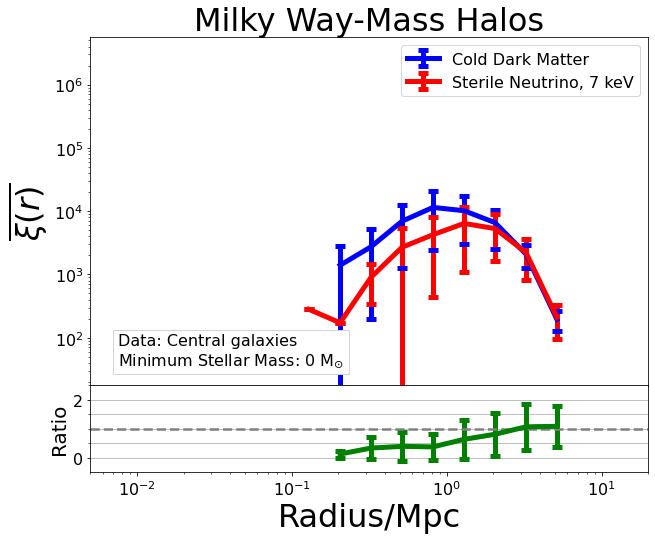

In [17]:
shell_galaxy, shell_halo = shell_corrfunc(issat = 0)

### Set M$_{\mathrm{min}}$ = 1000 M$_{\odot}$, centrals only

<ipython-input-14-119f98635098>:34: RuntimeWarning: Mean of empty slice
  CUTE_cdm, cdm_std = np.nanmean(shell['cdm'], axis = 0), np.nanstd(shell['cdm'], axis = 0)
<ipython-input-14-119f98635098>:35: RuntimeWarning: Mean of empty slice
  CUTE_wdm, wdm_std = np.nanmean(shell['wdm'], axis = 0), np.nanstd(shell['wdm'], axis = 0)


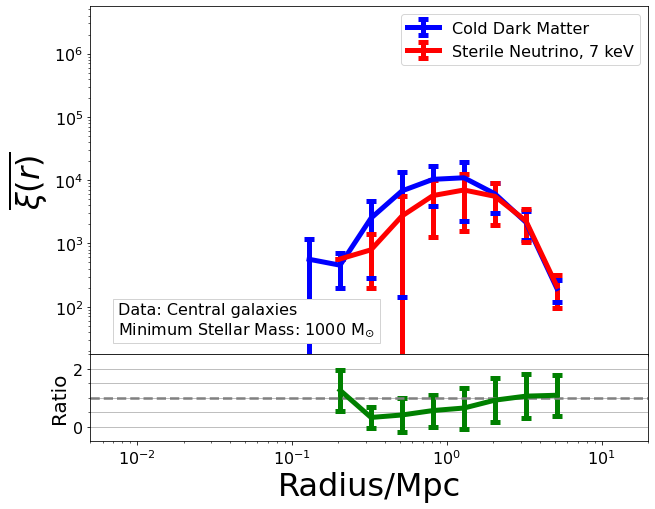

<ipython-input-14-119f98635098>:34: RuntimeWarning: Mean of empty slice
  CUTE_cdm, cdm_std = np.nanmean(shell['cdm'], axis = 0), np.nanstd(shell['cdm'], axis = 0)
C:\Users\Mahlet Shiferaw\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-14-119f98635098>:35: RuntimeWarning: Mean of empty slice
  CUTE_wdm, wdm_std = np.nanmean(shell['wdm'], axis = 0), np.nanstd(shell['wdm'], axis = 0)


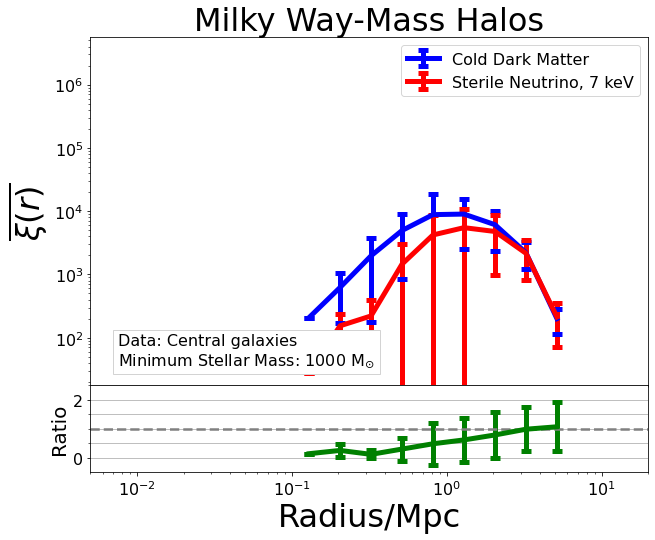

In [18]:
shell_galaxy_centrals, shell_halo_centrals = shell_corrfunc(m_min = 1000, issat = 0, save = True)

### Make a final multifigure plot

In [19]:
def plot(shell, grid0, grid1, m_min = 0, issat = 1, zip_file = '_galaxy_', label = True):    
        
    # plot the correlation function
    CUTE_cdm, cdm_std = np.nanmean(shell['cdm'], axis = 0), np.nanstd(shell['cdm'], axis = 0)
    CUTE_wdm, wdm_std = np.nanmean(shell['wdm'], axis = 0), np.nanstd(shell['wdm'], axis = 0)
    err = np.sqrt((wdm_std/CUTE_wdm)**2+(cdm_std/CUTE_cdm)**2)*CUTE_wdm/CUTE_cdm
    bins_old = np.logspace(-2, 0.8, 15)
    bins_new = 0.5*(bins_old[1:] + bins_old[:-1])

    if issat == 1:
        data = r'Data: Central and Satellite galaxies'
    else:
        data = r'Data: Central galaxies'
    textstr = '\n'.join((data, r'Minimum Stellar Mass: ' + str(m_min) + ' M$_{\odot}$'))
    props = dict(facecolor = 'white', edgecolor = 'lightgrey', pad = 5.0)

    grid0.errorbar(bins_new, CUTE_cdm, label = "Cold Dark Matter", linewidth = 5, color = "blue", 
                   yerr = cdm_std, capsize = 5, capthick = 5)
    grid0.errorbar(bins_new, CUTE_wdm, label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red", 
                   yerr = wdm_std, capsize = 5, capthick = 5)
    grid0.text(0.05, 0.125, textstr, transform = grid0.transAxes, fontsize = 16, verticalalignment = 'top', bbox = props)
    grid0.set_ylim(10**1.25, 10**6.75)
    grid0.set_yscale('Log')

    grid1.errorbar(bins_new, CUTE_wdm/CUTE_cdm, linewidth = 5, color = "green", yerr = err, capsize = 5, 
                   capthick = 5)
    grid1.set_xlabel("Radius/Mpc", fontsize = 32)
    grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
    grid1.yaxis.grid(which = "both")
    grid1.set_ylim(-1, 3)
    
    if label == True:
        grid0.set_ylabel(r"$\overline{\xi(r)}$", fontsize = 32)
        grid1.set_ylabel("Ratio",  fontsize = 20)
    else:
        grid0.legend(fontsize = 16)
        grid0.set_yticklabels([])
        grid1.set_yticklabels([])

    for grid in [grid0, grid1]:
        grid.tick_params(labelsize = 16)
        grid.set_xlim(5*10**-3, 2e1)
        grid.set_xscale('Log')
        grid.minorticks_on()

<ipython-input-19-7994c6efdb5b>:4: RuntimeWarning: Mean of empty slice
  CUTE_cdm, cdm_std = np.nanmean(shell['cdm'], axis = 0), np.nanstd(shell['cdm'], axis = 0)
<ipython-input-19-7994c6efdb5b>:5: RuntimeWarning: Mean of empty slice
  CUTE_wdm, wdm_std = np.nanmean(shell['wdm'], axis = 0), np.nanstd(shell['wdm'], axis = 0)


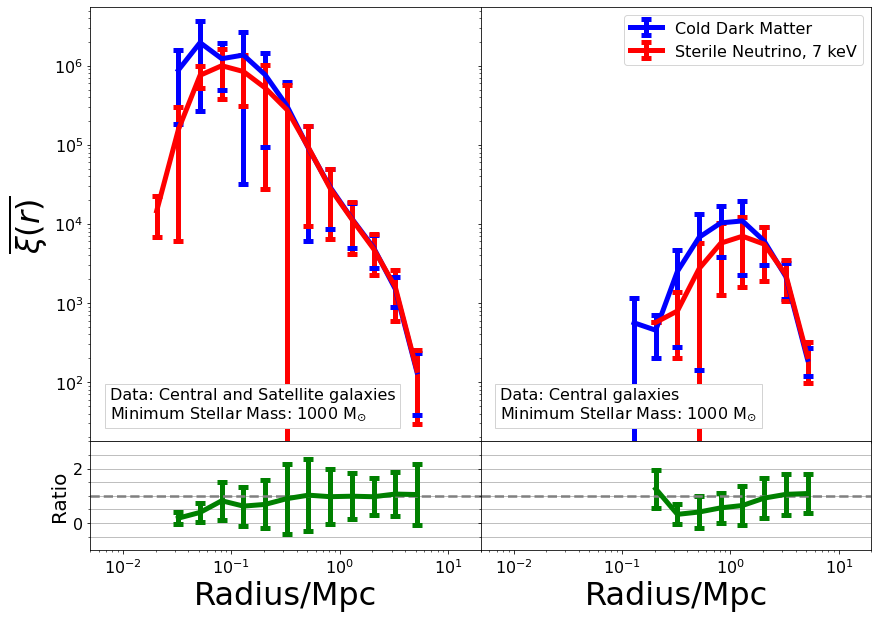

In [20]:
grid = gridspec.GridSpec(2, 2, height_ratios = [4, 1])
grid.update(hspace = 0, wspace = 0)
plt.figure(figsize = (14, 10))

grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])
grid2 = plt.subplot(grid[2])
grid3 = plt.subplot(grid[3])

plot(shell_galaxy_satellites, grid0, grid2, m_min = 1000)
plot(shell_galaxy_centrals, grid1, grid3, m_min = 1000, issat = 0, label = False)
plt.savefig('Images/Summer2020/corrfunc_local_galaxy_position_std_final.pdf', bbox_inches = "tight")
plt.show()